# AEON
#### create training dataset from aeon raw data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy.typing as npt
import warnings
import aeon
import aeon.io.api as aeon_api

from aeon.schema.schemas import exp02, social02
from aeon.analysis.utils import *
from dotmap import DotMap
from pathlib import Path
from scipy import stats


def get_experiment_times(
    root: str | os.PathLike, start_time: pd.Timestamp, end_time: pd.Timestamp
) -> DotMap:
    """
    Retrieve experiment start and stop times from environment states
    (i.e. times outside of maintenance mode) occurring within the
    given start and end times.

    Args:
        root (str or os.PathLike): The root path where epoch data is stored.
        start_time (pandas.Timestamp): Start time.
        end_time (pandas.Timestamp): End time.

    Returns:
        DotMap: A DotMap object containing two keys: 'start' and 'stop',
        corresponding to pairs of experiment start and stop times.

    Notes:
    This function uses the last 'Maintenance' event (if available, otherwise
    `end_time`) as the last 'Experiment' stop time. If the first retrieved state
    is 'Maintenance' (e.g. 'Experiment' mode entered before `start_time`),
    `start_time` is used as the first 'Experiment' start time.
    """

    experiment_times = DotMap()
    env_states = aeon.load(
        root,
        social02.Environment.EnvironmentState,
        # aeon.io.reader.Csv("Environment_EnvironmentState_*", ["state"]),
        start_time,
        end_time,
    )
    if env_states.empty:
        warnings.warn(
            "The environment state df is empty. "
            "Using input `start_time` and `end_time` as experiment times."
        )
        experiment_times.start = [start_time]
        experiment_times.stop = [end_time]
        return experiment_times
    if env_states["state"].iloc[-1] != "Maintenance":
        warnings.warn(
            "No 'Maintenance' event at the end of the search range. "
            "Using input `end_time` as last experiment stop time."
        )
        # Pad with a "Maintenance" event at the end
        env_states = pd.concat(
            [
                env_states,
                pd.DataFrame(
                    "Maintenance",
                    index=[end_time],
                    columns=env_states.columns,
                ),
            ]
        )
    # Use the last "Maintenance" event as end time
    end_time = (env_states[env_states.state == "Maintenance"]).index[-1]
    env_states = env_states[~env_states.index.duplicated(keep="first")]
    # Retain only events between visit start and stop times
    env_states = env_states.iloc[
        env_states.index.get_indexer([start_time], method="bfill")[
            0
        ] : env_states.index.get_indexer([end_time], method="ffill")[0]
        + 1
    ]
    # Retain only events where state changes (experiment-maintenance pairs)
    env_states = env_states[env_states["state"].ne(env_states["state"].shift())]
    if env_states["state"].iloc[0] == "Maintenance":
        warnings.warn(
            "No 'Experiment' event at the start of the search range. "
            "Using input `end_time` as last experiment stop time."
        )
        # Pad with an "Experiment" event at the start
        env_states = pd.concat(
            [
                pd.DataFrame(
                    "Experiment",
                    index=[start_time],
                    columns=env_states.columns,
                ),
                env_states,
            ]
        )
    experiment_times.start = env_states[
        env_states["state"] == "Experiment"
    ].index.values
    experiment_times.stop = env_states[
        env_states["state"] == "Maintenance"
    ].index.values

    return experiment_times


def exclude_maintenance_data(
    data: pd.DataFrame, experiment_times: DotMap
) -> pd.DataFrame:
    """
    Excludes rows not in experiment times (i.e., corresponding to maintenance times)
    from the given dataframe.

    Args:
        data (pandas.DataFrame): The data to filter. Expected to have a pandas.DateTimeIndex.
        experiment_times (DotMap): A DotMap object containing experiment start and stop times.

    Returns:
        pandas.DataFrame: A pandas DataFrame containing filtered data.
    """
    filtered_data = pd.concat(
        [
            data.loc[start:stop]
            for start, stop in zip(experiment_times.start, experiment_times.stop)
        ]
    )
    return filtered_data


def get_raw_tracking_data(
    root: str | os.PathLike,
    subj_id: str,
    start: pd.Timestamp,
    end: pd.Timestamp,
    source_reader: aeon.io.reader.Video = exp02.CameraTop.Video,
) -> pd.DataFrame:
    """
    Retrieve pos tracking and video data and assigns subject ID.

    Args:
        root (str or os.PathLike): The root path, or prioritised sequence of paths, where epoch data is stored.
        subj_id (str): The subject ID string to be assigned.
        start (pandas.Timestamp): The left bound of the time range to extract.
        end (pandas.Timestamp): The right bound of the time range to extract.
        source_reader (aeon.io.reader.Video, optional): The frame source reader. Default is exp02.CameraTop.Video.
    Returns:
        pandas.DataFrame: A pandas DataFrame containing pos tracking and video data, and subject ID.
    """

    subj_video = aeon_api.load(root, source_reader, start=start, end=end)
    subj_pos = aeon_api.load(root, exp02.CameraTop.Position, start=start, end=end)
    # replace "raw" in root with "processed"
    processed_root = root.replace("raw", "processed")
    if subj_video.empty:
        subj_video = aeon_api.load(processed_root, source_reader, start=start, end=end)
        warnings.warn("subj_video is empty, retrieving data from processed")
    if subj_pos.empty:
        subj_pos = aeon_api.load(
            processed_root, exp02.CameraTop.Position, start=start, end=end
        )
        warnings.warn("subj_pos is empty, retrieving data from processed")
    subj_data = pd.merge_asof(
        subj_video,
        subj_pos,
        left_index=True,
        right_index=True,
        direction="nearest",
        tolerance=pd.Timedelta("1ms"),
    )[["x", "y", "id", "area", "_frame", "_path"]]
    subj_data.dropna(inplace=True)
    subj_data["id"] = subj_id

    return subj_data


def sample_n_from_bins(
    subj_data: pd.DataFrame,
    n_samples: int = 1,
    n_bins: int = 50,
    range: npt.ArrayLike = [[0, 1440], [0, 1080]],
) -> pd.DataFrame:
    """
    Uniformly samples n number of data from x number of bins.

    Args:
        subj_data (pandas.DataFrame): A pandas DataFrame containing pos tracking and video data, and subject ID.
        n_samples (int, optional): The number of samples to take from each bin. Default is 1.
        n_bins (int, optional): The number of bins to use for sampling. Default is 50.
        range (list of lists, optional): The leftmost and rightmost edges of the bins along each dimension
            (if not specified explicitly in the bins parameters): [[xmin, xmax], [ymin, ymax]]. All values
            outside of this range will be considered outliers and not tallied in the histogram. Default is
            [[0, 1440], [0, 1080]].

    Returns:
        pandas.DataFrame: A pandas DataFrame containing uniformly-sampled pos tracking and video data, and subject ID.
    """

    hist_data = stats.binned_statistic_2d(
        subj_data.x,
        subj_data.y,
        values=subj_data,
        statistic="count",
        bins=n_bins,
        range=range,
    )
    subj_data["bin"] = hist_data.binnumber
    sampled_data = (
        subj_data.groupby(["bin"]).sample(n=n_samples, replace=True).drop_duplicates()
    )
    return sampled_data


def create_session_dataset(
    session: dict,
    subj_ids: list = None,
    plot_dist: bool = True,
) -> pd.DataFrame:
    """
    Creates a dataset for a given session dict.
    Args:
        session (dict): A dictionary containing the root path, subject IDs, and their start and end times.
        subj_ids (list, optional): A list of subject ids. If None, all subjects are selected.
        plot_dist (bool, optional): Whether to plot the 1d and 2d histograms of x, y pos tracking for each subject.
    Returns:
        pandas.DataFrame: A pandas dataframe containing uniformly-sampled pos tracking and video data, and subject ID.
    """
    all_subj_data = pd.DataFrame()
    if not subj_ids:
        subj_ids = session["subjects"].keys()
    for subj in subj_ids:
        subj_dict = {
            "id": subj,
            "root": session.get("root", session["subjects"][subj].get("root")),
            "start": session["subjects"][subj]["start"],
            "end": session["subjects"][subj]["end"],
        }
        subj_data = (
            create_subject_dataset(
                subj_dict,
                min_area=500,
                n_samples=4,
                n_bins=10,
            )  # sample fewer points for manual annotation
            if "multi_" in subj
            else create_subject_dataset(
                subj_dict,
            )
        )
        all_subj_data = pd.concat([all_subj_data, subj_data])
    if plot_dist:
        fig = plot_position_histograms(all_subj_data)
        fig.show()
    return all_subj_data


def plot_position_histograms(data: pd.DataFrame, n_bins: int = 50) -> plt.Figure:
    """
    Plots the 1d and 2d histograms of x, y pos tracking for each subject in a given DataFrame.
    Args:
        data (pandas.DataFrame): A pandas DataFrame containing x, y pos tracking and subject ID(s).
        n_bins (int, optional): The number of bins to use for plotting histograms. Default is 50.
    Returns:
        matplotlib.pyplot: A plot containing 1d and 2d histograms of x, y pos tracking for each subject.
    """
    subj_ids = data["id"].unique()
    fig, ax = plt.subplots(2, len(subj_ids))
    n_bins = 50
    if len(subj_ids) == 1:
        data[["x", "y"]].plot.hist(bins=n_bins, alpha=0.5, ax=ax[0], title=subj_ids[0])
        ax[1].hist2d(
            data.x,
            data.y,
            bins=(n_bins, n_bins),
            cmap=plt.cm.jet,
        )
    else:
        for i, subj_id in enumerate(subj_ids):
            subj_data = data[data["id"] == subj_id]
            subj_data[["x", "y"]].plot.hist(
                bins=n_bins, alpha=0.5, ax=ax[0, i], title=subj_id
            )
            ax[1, i].hist2d(
                subj_data.x, subj_data.y, bins=(n_bins, n_bins), cmap=plt.cm.jet
            )

    plt.tight_layout()
    return fig


def create_subject_dataset(
    subject: dict,
    min_area: float = None,
    n_samples: int = 1,
    n_bins: int = 50,
) -> pd.DataFrame:
    """
    Creates a dataset for a given subject dict.

    Args:
        subject (dict): A dictionary containing the root path, subject ID, and their start and end times.
        min_area (float, optional): The minimum area of the subject to be included in the dataset. Default is None.
        n_samples (int, optional): The number of samples to take from each bin. Default is 1.
        n_bins (int, optional): The number of bins to use for sampling. Default is 50.

    Returns:
        pandas.DataFrame: A pandas DataFrame containing uniformly-sampled pos tracking and video data, and subject ID.
    """
    subj_data = get_raw_tracking_data(
        subject["root"],
        subject["id"],
        subject["start"],
        subject["end"],
    )
    if min_area:
        subj_data = subj_data[subj_data.area >= min_area]  # when animals fuse
    subj_data = sample_n_from_bins(subj_data, n_samples=n_samples, n_bins=n_bins)
    return subj_data


def create_fully_labelled_dataset(session: dict, subj_ids: list = None) -> pd.DataFrame:
    """
    Creates a fully labelled dataset for all or selected subjects of
    a given session dict. Useful to "bookmark" frames for use with SLEAP's
    predict "only-labeled-frames" option.

    Args:
        session (dict): A session dictionary.
        subj_ids (list, optional): A list of subject ids. If None, all
            subjects are selected.
    Returns:
        pandas.DataFrame: A pandas DataFrame containing pos tracking,
            video data, and subject ID.
    """
    all_subj_data = pd.DataFrame()
    if not subj_ids:
        subj_ids = session["subjects"].keys()
        subj_ids = [subj for subj in subj_ids if "multi_" not in subj]
    for subj in subj_ids:
        root = session.get("root", session["subjects"][subj].get("root"))
        subj_data = get_raw_tracking_data(
            root,
            subj,
            session["subjects"][subj]["start"],
            session["subjects"][subj]["end"],
            source_reader=exp02.CameraTop.Video,
        )
        all_subj_data = pd.concat([all_subj_data, subj_data])

    return all_subj_data

In [2]:
# dictionaries for each session
aeon2 = {
    "root": "/ceph/aeon/aeon/data/raw/AEON2/experiment0.2/",
    "subjects": {
        "BAA-1101818": {
            "start": pd.Timestamp("2022-06-23 08:39:04.261089801"),
            "end": pd.Timestamp("2022-06-23 11:14:46.121759892"),
        },
        "BAA-1101819": {
            "start": pd.Timestamp("2022-06-21 13:28:10.593659878"),
            "end": pd.Timestamp("2022-06-21 16:34:29.241280079"),
        },
    },
    "session": "BAA-1101818_819",
    "multianimal_videos": [
        r"Z:\aeon\data\raw\AEON2\experiment0.2\2022-06-22T08-51-10\CameraTop\CameraTop_2022-06-22T11-00-00.avi"
    ],
}

aeon3 = {
    "root": "Z:/aeon/data/raw/AEON3/presocial0.1",
    "subjects": {
        "AEON3_NTP": {
            "start": pd.Timestamp("2023-03-03 16:40:00"),
            "end": pd.Timestamp("2023-03-03 16:55:00"),
        },
        "AEON3_TP": {
            "start": pd.Timestamp("2023-03-03 17:01:00"),
            "end": pd.Timestamp("2023-03-03 17:22:00"),
        },
        "multi_animal": {
            "start": pd.Timestamp("2023-03-03 17:23:00"),
            "end": pd.Timestamp("2023-03-03 17:43:00"),
        },
    },
    "session": "AEON3_NTP_TP_local",
    "multianimal_videos": [
        r"C:\Users\chuan\Documents\SLEAP_Test\aeon3_multi\CameraTop_2023-03-03T17-00-00_multianimal.avi"
    ],
    # multianimal "2023-03-03 17:23:00" "2023-03-03 17:43:00"
}

aeon3b = {
    "root": "Z:/aeon/data/raw/AEON3/presocial0.1",
    "subjects": {
        "AEON3B_NTP": {
            "start": pd.Timestamp("2023-03-16 15:05:00"),
            "end": pd.Timestamp("2023-03-16 15:44:00"),
        },
        "AEON3B_TP": {
            "start": pd.Timestamp("2023-03-16 16:00:00"),
            "end": pd.Timestamp("2023-03-16 16:36:00"),
        },
        "multi_animal": {
            "start": pd.Timestamp("2023-03-16 16:37:00"),
            "end": pd.Timestamp("2023-03-16 17:19:00"),
        },
    },
    "session": "AEON3B_NTP_TP_local",
    "multianimal_videos": [
        r"C:\Users\chuan\Documents\SLEAP_Test\aeon3_multi\CameraTop_2023-03-16T16-00-00_multianimal.avi",
        r"C:\Users\chuan\Documents\SLEAP_Test\aeon3_multi\CameraTop_2023-03-16T17-00-00_multianimal.avi",
    ],
    # multianimal "2023-03-16 16:37:00" "2023-03-16 17:19:00"
}

aeon3b_pattern = {
    "root": "Z:/aeon/data/raw/AEON3/presocial0.1/",
    "subjects": {
        "AEON3B_NTP": {
            "start": pd.Timestamp("2023-03-29 09:40:40"),
            "end": pd.Timestamp("2023-03-29 10:07:00"),
        },
        "AEON3B_TP1": {
            "start": pd.Timestamp("2023-03-29 10:10:44"),
            "end": pd.Timestamp("2023-03-29 10:46:30"),
        },
        "AEON3B_TP2": {
            "start": pd.Timestamp("2023-03-29 10:50:10"),
            "end": pd.Timestamp("2023-03-29 11:22:00"),
        },
        "multi_animal": {
            "start": pd.Timestamp("2023-03-29 11:23:30"),
            "end": pd.Timestamp("2023-03-29 12:31:00"),
        },
    },
    "session": "AEON3B_pattern_local",
    "multianimal_videos": [
        # TP1 and TP2: 11:22:37 - 11:22:57
        r"C:\Users\chuan\Documents\SLEAP_Test\aeon3_multi\CameraTop_2023-03-29T11-00-00_TP1TP2.avi",
        # all mice: 11:23:30 - 12:31:00
        r"C:\Users\chuan\Documents\SLEAP_Test\aeon3_multi\CameraTop_2023-03-29T11-00-00_multianimal.avi",
        r"C:\Users\chuan\Documents\SLEAP_Test\aeon3_multi\CameraTop_2023-03-29T12-00-00_multianimal.avi",  # all mice
    ],
}

aeon3b_pattern_nest = {
    "root": "Z:/aeon/data/raw/AEON3/presocial0.1/",
    "subjects": {
        "AEON3B_NTP": {
            "start": pd.Timestamp("2023-03-29 09:40:40"),
            "end": pd.Timestamp("2023-03-29 10:07:00"),
        },
        "AEON3B_TP1": {
            "start": pd.Timestamp("2023-03-29 10:10:44"),
            "end": pd.Timestamp("2023-03-29 10:46:30"),
        },
        "AEON3B_TP2": {
            "start": pd.Timestamp("2023-03-29 10:50:10"),
            "end": pd.Timestamp("2023-03-29 11:22:00"),
        },
        "multi_animal": {
            "start": pd.Timestamp("2023-03-29 11:23:30"),
            "end": pd.Timestamp("2023-03-29 12:31:00"),
        },
    },
    "nest_coords": [
        (1223, 475),
        (1223, 588),
        (1352, 479),
        (1352, 581),
    ],
    "session": "AEON3B_pattern_local_nest",
    "multianimal_videos": [
        r"Y:\ProjectAeon\sleap_tracking\CameraNest_2023-03-29T11-12-00_pattern_nest.avi"  # all mice
    ],
}

aeon3b_pattern_tattoo = {
    "root": "Z:/aeon/data/raw/AEON3/presocial0.1/",
    "subjects": {
        "AEON3B_NTP": {  # BAA-1103352
            "start": pd.Timestamp("2023-06-16 16:13:30"),
            "end": pd.Timestamp("2023-06-16 17:00"),
        },
        "AEON3B_TP1": {  # BAA-1103353
            "start": pd.Timestamp("2023-06-16 17:04"),
            "end": pd.Timestamp("2023-06-16 18:04"),
        },
        "AEON3B_TP2": {  # BAA-1103351
            "start": pd.Timestamp("2023-06-16 18:08:19"),
            "end": pd.Timestamp("2023-06-16 18:38:52"),
        },
        "multi_animal": {
            "start": pd.Timestamp("2023-06-16 18:41:30"),
            "end": pd.Timestamp("2023-06-16 19:12:00"),
        },
    },
    "session": "AEON3B_pattern_tattoo",
    "multianimal_videos": [
        r"Y:\ProjectAeon\sleap_tracking\CameraTop_2023-06-16T18-19-00_pattern_tattoo.avi",  # all mice
    ],
}

aeon3b_pattern_tattoo2 = {
    "root": "Z:/aeon/data/raw/AEON3/multianimal-test/",
    "subjects": {
        "AEON3B_NTP": {  # BAA-1103352
            "start": pd.Timestamp("2023-07-04 16:28:10"),
            "end": pd.Timestamp("2023-07-04 17:01:57"),
        },
        "AEON3B_TP1": {  # CAA-1120139
            "start": pd.Timestamp("2023-07-04 17:06:22"),
            "end": pd.Timestamp("2023-07-04 17:34:52"),
        },
        "AEON3B_TP2": {  # BAA-1103351
            "start": pd.Timestamp("2023-07-04 15:36:19"),
            "end": pd.Timestamp("2023-07-04 16:16:19"),
        },
        "multi_animal": {
            "start": pd.Timestamp("2023-07-04 17:37:08"),
            "end": pd.Timestamp("2023-07-04 18:10:13"),
        },
    },
    "session": "AEON3B_pattern_tattoo2",
    "multianimal_videos": [
        r"Y:\ProjectAeon\sleap_tracking\CameraTop_2023-07-04T17-18-00_pattern_tattoo.avi",  # all mice
    ],
}

aeon3b_pattern_tattoo3 = {
    "root": "Z:/aeon/data/raw/AEON3/multianimal-test/",
    "subjects": {
        "AEON3B_NTP": {  # BAA-1103352
            "start": pd.Timestamp("2023-07-04 16:28:10"),
            "end": pd.Timestamp("2023-07-04 17:01:57"),
        },
        "AEON3B_TP1": {  # BAA-1103369
            "start": pd.Timestamp("2023-07-28 14:24:00"),
            "end": pd.Timestamp("2023-07-28 15:15:00"),
        },
        "AEON3B_TP2": {  # BAA-1103351
            "start": pd.Timestamp("2023-07-04 15:36:19"),
            "end": pd.Timestamp("2023-07-04 16:16:19"),
        },
        "multi_animal": {
            "start": pd.Timestamp("2023-07-28 15:21:00"),
            "end": pd.Timestamp("2023-07-28 16:18:00"),
        },
        "multi_animal2": {
            "start": pd.Timestamp("2023-08-01 10:19:00"),
            "end": pd.Timestamp("2023-08-01 11:07:00"),
        },
        "multi_animal3": {
            "start": pd.Timestamp("2023-08-03 10:40:00"),
            "end": pd.Timestamp("2023-08-03 11:28:00"),
        },
        "multi_animal4": {
            "start": pd.Timestamp("2023-08-08 14:14:10.119999886"),
            "end": pd.Timestamp("2023-08-08 15:01:32.288000107"),
        },
        "multi_animal5": {
            "start": pd.Timestamp("2023-08-11 11:54:01.340000153"),
            "end": pd.Timestamp("2023-08-11 13:20:36.303999901"),
        },
    },
    "session": "AEON3B_pattern_tattoo3",
}

social_01 = {
    "subjects": {
        "CAA-1120747": {  # CAA-1120747
            "root": "Z:/aeon/data/raw/AEON4/social0.1/",
            "start": pd.Timestamp("2023-11-27 13:00:00"),
            "end": pd.Timestamp("2023-11-27 14:00:00"),
        },
        "CAA-1120746": {  # CAA-1120746
            "root": "Z:/aeon/data/raw/AEON3/social0.1/",
            "start": pd.Timestamp("2023-11-22 12:00:00"),
            "end": pd.Timestamp("2023-11-22 13:00:00"),
        },
    },
    "session": "social_01",
}

aeon3_social_dev_b5350ff = {
    "root": "Z:/aeon/data/raw/AEON3/model-training/",
    "subjects": {
        "BAA-1104047": {  # no tattoo
            "start": pd.Timestamp("2024-01-09 16:14:00"),
            "end": pd.Timestamp("2024-01-09 16:45:00"),
        },
        "BAA-1104045": {  # tattooed
            "start": pd.Timestamp("2024-01-09 16:50:00"),
            "end": pd.Timestamp("2024-01-09 17:20:00"),
        },
        "multi_animal": {
            "start": pd.Timestamp("2024-01-09 15:37:00"),
            "end": pd.Timestamp("2024-01-09 16:09:00"),
        },
    },
    "session": "aeon3_social_dev_b5350ff",
}

aeon4_social_dev_b5350ff = {
    "root": "Z:/aeon/data/raw/AEON4/model-training/",
    "subjects": {
        "BAA-1104049": {  # no tattoo
            "start": pd.Timestamp("2024-01-09 16:46:00"),
            "end": pd.Timestamp("2024-01-09 17:15:00"),
        },
        "BAA-1104048": {  # tattooed
            "start": pd.Timestamp("2024-01-09 16:10:00"),
            "end": pd.Timestamp("2024-01-09 16:39:00"),
        },
        "multi_animal": {
            "start": pd.Timestamp("2024-01-09 15:21:00"),
            "end": pd.Timestamp("2024-01-09 16:07:00"),
        },
    },
    "session": "aeon4_social_dev_b5350ff",
}

aeon4_social_dev_b5350ff2 = {
    "root": "Z:/aeon/data/raw/AEON4/model-training/",
    "subjects": {
        "BAA-1104049": {  # no tattoo
            "start": pd.Timestamp("2024-01-21 20:33:00"),
            "end": pd.Timestamp("2024-01-21 21:13:00"),
        },
        "BAA-1104048": {  # tattooed
            "start": pd.Timestamp("2024-01-21 19:47:00"),
            "end": pd.Timestamp("2024-01-21 20:27:00"),
        },
        "multi_animal": {
            "start": pd.Timestamp("2024-01-21 19:12:00"),
            "end": pd.Timestamp("2024-01-21 19:43:00"),
        },
    },
    "session": "aeon4_social_dev_b5350ff2",
}

aeon3_social_dev_b5350ff2 = {
    "root": "/ceph/aeon/aeon/data/raw/AEON3/social0.2/",
    "subjects": {
        "BAA-1104047": {  # no tattoo
            "start": pd.Timestamp("2024-02-05 15:44:00"),
            "end": pd.Timestamp("2024-02-05 17:00:00"),
        },
        "BAA-1104045": {  # tattooed
            "start": pd.Timestamp("2024-01-31 11:29:00"),
            "end": pd.Timestamp("2024-01-31 13:00:00"),
        },
    },
    "session": "aeon3_social_dev_b5350ff2",
}

aeon3_social_310524 = {
    "root": "/ceph/aeon/aeon/data/raw/AEON3/social0.2/",
    "subjects": {
        "BAA-1104519": {  # no tattoo
            "start": pd.Timestamp("2024-05-31 13:21:00"),
            "end": pd.Timestamp("2024-05-31 14:00:00"),
        },
        "BAA-1104518": {  # tattooed
            "start": pd.Timestamp("2024-05-31 15:05:00"),
            "end": pd.Timestamp("2024-05-31 15:50:00"),
        },
        "multi_animal": {
            "start": pd.Timestamp("2024-05-31 14:16:00"),
            "end": pd.Timestamp("2024-05-31 15:00:00"),
        },
    },
    "session": "aeon3_social_310524",
}

In [ ]:
# load subject states
start = pd.Timestamp("2024-05-31 00:00:00")
end = pd.Timestamp("2024-05-31 23:59:59")
aeon_api.load(
    "/ceph/aeon/aeon/data/raw/AEON3/social0.2/",
    social02.Environment.SubjectState,
    start=start,
    end=end,
)

In [ ]:
# load environment states
aeon_api.load(
    "/ceph/aeon/aeon/data/raw/AEON3/social0.2/",
    social02.Environment.EnvironmentState,
    start=start,
    end=end,
)

,x,y,area,_frame,_path,bin
id,,,,,,
BAA-1104518,1139,1139,1139,1139,1139,1139
BAA-1104519,394,394,394,394,394,394
multi_animal,117,117,117,117,117,117


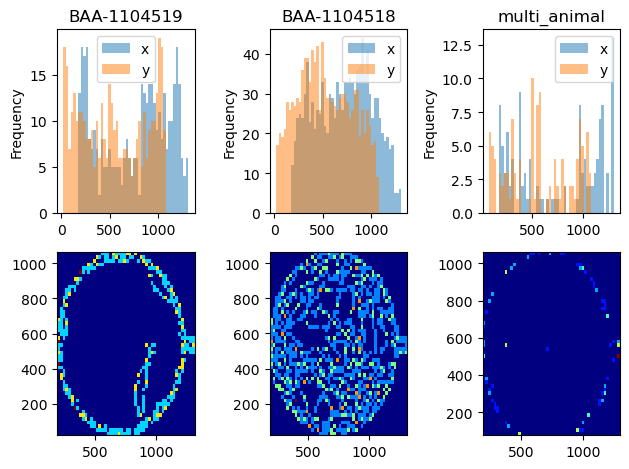

In [5]:
# extract single + multi-animal frames
all_subj_data = create_session_dataset(aeon3_social_310524)
all_subj_data.groupby(["id"]).count()

In [ ]:
# Sample additional multi_animal data (without area threshold, i.e. animals are not close to each other)
subj_dict = {
    "id": "multi_animal",
    "root": aeon3_social_310524["root"],
    "start": aeon3_social_310524["subjects"]["multi_animal"]["start"],
    "end": aeon3_social_310524["subjects"]["multi_animal"]["end"],
}
multi = create_subject_dataset(
    subj_dict,
    n_samples=1,
    n_bins=20,
)  # sample random points regardless of area

In [ ]:
# Sample additional single animal data
subj_dict = {
    "id": "BAA-1104519",
    "root": aeon3_social_310524["root"],
    "start": aeon3_social_310524["subjects"]["BAA-1104519"]["start"],
    "end": aeon3_social_310524["subjects"]["BAA-1104519"]["end"],
}
BAA1104519 = create_subject_dataset(
    subj_dict,
    n_samples=3,
    n_bins=50,
)

In [ ]:
# replace "BAA-1104519" data with resampled data and merge with multi_animal data
all_subj_data = all_subj_data[all_subj_data["id"] != "BAA-1104519"]
all_subj_data = pd.concat([all_subj_data, multi, BAA1104519])
# drop duplicates
all_subj_data.drop_duplicates(inplace=True)
all_subj_data.groupby(["id"]).count()
# save to csv
all_subj_data.to_csv(f'{aeon3_social_310524["session"]}.csv')

In [ ]:
# create fully labelled datasets for SLEAP model validation
single_animal_data = create_fully_labelled_dataset(
    aeon3_social_310524,
    subj_ids=[
        subj for subj in aeon3_social_310524["subjects"].keys() if "multi_" not in subj
    ],
).sample(
    frac=0.1
)  # sample only 10% of the data
single_animal_data.to_csv(f'{aeon3_social_310524["session"]}_single_animal_frames.csv')
multi_animal_data = create_fully_labelled_dataset(
    aeon3_social_310524,
    subj_ids=[
        subj for subj in aeon3_social_310524["subjects"].keys() if "multi_" in subj
    ],
).sample(
    frac=0.1
)  # sample only 10% of the data
multi_animal_data.to_csv(f'{aeon3_social_310524["session"]}_multi_animal_frames.csv')

In [ ]:
# retrieve timestamps with temporal discontinuities for RETRAINING
import numpy as np


def adjust_ids(group, classes):
    if len(group["id"].unique()) != 2:
        # Get the id of the row with the higher class_likelihood
        max_id = group.loc[group["class_likelihood"].idxmax(), "id"]
        # Set the id of the row with the lower class_likelihood to the id that's not max_id
        group.loc[group["class_likelihood"].idxmin(), "id"] = [
            id for id in classes if id != max_id
        ][0]
    return group


# load SLEAP Pose data
root = "/ceph/aeon/aeon/data/raw/AEON3/social0.2/"
start_time = pd.Timestamp("2024-02-09 17:00")
end_time = pd.Timestamp("2024-02-09 18:00")
exp_times = get_experiment_times(root, start_time, end_time)
pos = aeon_api.load(root, social02.CameraTop.Pose, start=start_time, end=end_time)
pos = exclude_maintenance_data(pos, exp_times)
pos["class"] = pos["class"].astype(int)
classes = [
    "BAA-1104045",
    "BAA-1104047",
]  # from SLEAP model config # AEON3["BAA-1104045", "BAA-1104047"] # AEON4["BAA-1104048", "BAA-1104049"]
# assign subject IDs
pos["id"] = pos["class"].map(lambda x: classes[x])
pos_sorted = pos.sort_values(by=["class", pos.index.name])
pos_sorted["dist"] = (
    pos_sorted.groupby("class")[["x", "y"]]
    .diff()
    .apply(lambda x: np.linalg.norm(x), axis=1)
)
# set 100 as threshold for temporal discontinuities
violations = pos_sorted[pos_sorted["dist"] > 100]
sampled_violations = (
    violations.groupby("class")
    .apply(sample_n_from_bins, n_samples=2, n_bins=10, include_groups=False)
    .reset_index()
    .set_index("time")
    .sort_index()
)
# retrieve frames with temporal discontinuities
top_frames = aeon_api.load(
    root, social02.CameraTop.Video, time=sampled_violations.index.unique()
)
# merge frames with pose data
top_frames_pos = pos[["id", "x", "y", "class_likelihood"]].merge(
    top_frames, left_index=True, right_index=True, how="inner"
)
top_frames_pos = top_frames_pos.reset_index()
top_frames_pos = (
    top_frames_pos.groupby("time")[top_frames_pos.columns]
    .apply(adjust_ids, classes=classes)
    .set_index("time")
)
top_frames_pos.to_csv(
    "/ceph/aeon/aeon/code/scratchpad/sleap/social0.2/AEON3/aeon3_social_02_retrain.csv"
)

# SLEAP

In [1]:
import pandas as pd
import random
import sleap
import numpy as np

from typing import Optional, Dict
from sleap.io.pathutils import fix_path_separator
from sleap.gui.suggestions import VideoFrameSuggestions
from sleap.nn.config import *
from sleap.nn.inference import main as sleap_track
from sleap.nn.inference import TopDownMultiClassPredictor

In [2]:
def remove_nan_tracks(labels: sleap.Labels) -> sleap.Labels:
    """
    Removes instances from SLEAP Labels object where track = None.

    Args:
        labels (sleap.Labels): A SLEAP Labels object.
    Returns:
        sleap.Labels: A SLEAP Labels object with only tracked instances in each frame.
    """
    lfs = [lf.remove_untracked() for lf in labels.labeled_frames]
    return sleap.Labels(
        labeled_frames=lfs,
        videos=labels.videos,
        skeletons=labels.skeletons,
        tracks=labels.tracks,
    )


def generate_slp_dataset(
    subj_data: pd.DataFrame,
    skeleton: sleap.Skeleton,
    tracks_dict: Optional[Dict[str, sleap.Track]] = None,
) -> sleap.Labels:
    """
    Generates .slp dataset for a given session dict.

    Args:
        subj_data (pandas.DataFrame): A pandas DataFrame containing the labeled data for a given session.
        skeleton (sleap.Skeleton): A sleap Skeleton object.
        tracks_dict (dict, optional): A dictionary containing track names and their corresponding sleap Track objects.
            If None, a new dictionary is created from the subject IDs in the input data. Default is None.
    Returns:
        sleap.Labels: A SLEAP Labels object containing labeled frames.
    """

    # create tracks dictionary from subj_ids that are not multi_animal
    if not tracks_dict:
        tracks_dict = {
            subj: sleap.Track(spawned_on=0, name=subj)
            for subj in subj_data["id"].unique()
            if "multi_" not in subj
        }

    lfs = []

    # create video dictionary from new labels
    videos_dict = {
        video: sleap.Video.from_filename(video, grayscale=True)
        for video in subj_data._path.unique()
    }

    # for each unique frame, create a new labeled frame
    for _, row in subj_data.drop_duplicates(subset=["_path", "_frame"]).iterrows():
        instances = []
        if "multi_" in row.id:
            # duplicate instance for each track
            for track in tracks_dict.keys():
                instances.append(
                    sleap.Instance(
                        skeleton=skeleton,
                        track=tracks_dict[track],
                        points={"centroid": sleap.instance.Point(row.x, row.y)},
                    )
                )
        else:
            # create a new instance for each row
            instances += [
                (
                    sleap.Instance(
                        skeleton=skeleton,
                        track=tracks_dict[inst.id],
                        points={"centroid": sleap.instance.Point(inst.x, inst.y)},
                    )
                )
                for _, inst in subj_data[
                    (subj_data["_path"] == row._path)
                    & (subj_data["_frame"] == row._frame)
                ].iterrows()
            ]
        # create a new labeled frame
        lf = sleap.instance.LabeledFrame(
            video=videos_dict[row._path],
            frame_idx=row._frame,
            instances=instances,
        )
        lfs.append(lf)

    return sleap.Labels(labeled_frames=lfs)


def update_slp_video_paths(
    labels: "sleap.Labels", old_path: str, new_path: str
) -> sleap.Labels:
    """
    Updates video paths in a SLEAP labels object (e.g., to move training from local to remote machine).

    Args:
        labels (sleap.Labels): A SLEAP Labels object.
        old_path (str): Old path to video files.
        new_path (str): New path to video files.

    Returns:
        sleap.Labels: A SLEAP Labels object with updated video paths.

    """

    videos = [
        sleap.Video.from_filename(
            fix_path_separator(vid.filename).replace(old_path, new_path), grayscale=True
        )
        for vid in labels.videos
    ]

    lfs = []
    for lf in labels.labeled_frames:
        lf = sleap.instance.LabeledFrame(
            video=videos[labels.videos.index(lf.video)],
            frame_idx=lf.frame_idx,
            instances=lf.instances,
        )
        lfs.append(lf)

    return sleap.Labels(
        labeled_frames=lfs,
        videos=videos,
        skeletons=labels.skeletons,
        tracks=labels.tracks,
    )

In [3]:
# create new skeleton
skeleton = sleap.Skeleton()
skeleton.add_node("centroid")

In [5]:
# generate slp training dataset for all subjects
subj_data = pd.read_csv(f'{aeon3_social_310524["session"]}.csv')
labels = generate_slp_dataset(subj_data, skeleton)
sleap.Labels.save_file(labels, f'{aeon3_social_310524["session"]}.slp')

In [ ]:
# generate separate single, multi-animal .slp datasets for prediction/evaluation
# single-animal frames are GT for evaluation
# multi-animal frames are labelled to be used as bookmarks for prediction
csv_files = [
    f'{aeon3_social_310524["session"]}_single_animal_frames.csv',
    f'{aeon3_social_310524["session"]}_multi_animal_frames.csv',
]
tracks_dict = {
    subj: sleap.Track(spawned_on=0, name=subj)
    for subj in aeon3_social_310524["subjects"].keys()
    if "multi_" not in subj
}
for csv_file in csv_files:
    subj_data = pd.read_csv(csv_file)
    labels = generate_slp_dataset(subj_data, skeleton, tracks_dict=tracks_dict)
    labels = update_slp_video_paths(
        labels=labels, old_path="Z:", new_path="/ceph/aeon")
    sleap.Labels.save_file(labels, f"{Path(csv_file).stem}_ceph.slp")

In [4]:
# generate slp retrain dataset
subj_data = pd.read_csv(
    "/ceph/aeon/aeon/code/scratchpad/sleap/social0.2/AEON3/aeon3_social_02_retrain.csv"
)
labels = generate_slp_dataset(subj_data, skeleton)
sleap.Labels.save_file(
    labels,
    "/ceph/aeon/aeon/code/scratchpad/sleap/social0.2/AEON3/aeon3_social_02_retrain.slp",
)

#### train

In [2]:
# set initial parameters
subj_id = f'{aeon3b_pattern_tattoo3["session"]}'
run_name_centroid = f"{subj_id}_topdown_top.centroid"
run_name_centered_instance = f"{subj_id}_topdown_top.centered_instance_multiclass"
root = "/ceph/aeon/aeon/code/scratchpad/sleap/tail_pattern/"
runs_folder = root + "models/"
predictions_folder = root + "predictions/"
groundtruth_folder = root + "groundtruth/"

try:
    skeleton
except NameError:
    # create new skeleton
    skeleton = sleap.Skeleton()
    skeleton.add_node("centroid")

In [ ]:
# update local video paths to ceph
new_labels = update_slp_video_paths(
    labels=sleap.load_file(f"{subj_id}.slp"), old_path="Z:", new_path="/ceph/aeon"
)
sleap.Labels.save_file(new_labels, f"{root}{subj_id}.slp")

In [ ]:
# split labels into train/val/test
labels = sleap.load_file(f"{root}{subj_id}.slp")

# generate a 0.8/0.1/0.1 train/val/test split
labels_train, labels_val_test = labels.split(n=0.8)
labels_val, labels_test = labels_val_test.split(n=0.5)

# Save with images
labels_train.save(f"{root}{subj_id}.train.pkg.slp")  # , with_images=True)
labels_val.save(f"{root}{subj_id}.val.pkg.slp")  # , with_images=True)
labels_test.save(f"{root}{subj_id}.test.pkg.slp")  # , with_images=True)

In [ ]:
# centroid model
# initalise default training job config
cfg = TrainingJobConfig()
cfg.data.labels.training_labels = f"{root}{subj_id}.train.pkg.slp"
cfg.data.labels.validation_labels = f"{root}{subj_id}.val.pkg.slp"
cfg.data.labels.test_labels = f"{root}{subj_id}.test.pkg.slp"

# preprocessing and training params
cfg.data.preprocessing.input_scaling = 0.75  # 0.5
cfg.data.instance_cropping.center_on_part = "centroid"
cfg.data.instance_cropping.crop_size = 96  # set crop size manually
cfg.optimization.augmentation_config.rotate = True
cfg.optimization.epochs = 600  # 200
cfg.optimization.batch_size = 4

cfg.optimization.initial_learning_rate = 0.0001
cfg.optimization.learning_rate_schedule.reduce_on_plateau = True
cfg.optimization.learning_rate_schedule.reduction_factor = 0.5
cfg.optimization.learning_rate_schedule.plateau_min_delta = 1e-06
cfg.optimization.learning_rate_schedule.plateau_patience = 20  # 5
cfg.optimization.learning_rate_schedule.plateau_cooldown = 3
cfg.optimization.learning_rate_schedule.min_learning_rate = 1e-08

cfg.optimization.early_stopping.stop_training_on_plateau = True
cfg.optimization.early_stopping.plateau_min_delta = 1e-08
cfg.optimization.early_stopping.plateau_patience = 30  # 20

# configure nn and model
cfg.model.backbone.unet = UNetConfig(
    max_stride=16,
    filters=16,
    filters_rate=2.00,
    output_stride=2,
    # up_interpolate=True, # save computations but may lower accuracy
)
cfg.model.heads.centroid = CentroidsHeadConfig(
    anchor_part="centroid", sigma=2.5, output_stride=2
)

# configure outputs
cfg.outputs.run_name = run_name_centroid
cfg.outputs.save_outputs = True
cfg.outputs.runs_folder = runs_folder
cfg.outputs.save_visualizations = True
cfg.outputs.checkpointing.initial_model = True
cfg.outputs.checkpointing.best_model = True

trainer = sleap.nn.training.Trainer.from_config(cfg)
trainer.setup()
trainer.train()

In [ ]:
# part detection model: centered instance + multi-class
# initalise default training job config
cfg = TrainingJobConfig()

# update path to 0.8/0.1/0.1 train/val/test split
cfg.data.labels.training_labels = f"{root}{subj_id}.train.pkg.slp"
cfg.data.labels.validation_labels = f"{root}{subj_id}.val.pkg.slp"
cfg.data.labels.test_labels = f"{root}{subj_id}.test.pkg.slp"
cfg.data.labels.skeletons = [skeleton]  # load skeleton

# preprocessing and training params
cfg.data.preprocessing.input_scaling = 1.0
cfg.data.instance_cropping.center_on_part = "centroid"
cfg.data.instance_cropping.crop_size = 96  # set crop size manually
cfg.optimization.augmentation_config.rotate = True
cfg.optimization.epochs = 600
cfg.optimization.batch_size = 8  # 4

cfg.optimization.initial_learning_rate = 0.0001
cfg.optimization.learning_rate_schedule.reduce_on_plateau = True
cfg.optimization.learning_rate_schedule.reduction_factor = 0.1  # 0.5
cfg.optimization.learning_rate_schedule.plateau_min_delta = 1e-08  # 1e-06
cfg.optimization.learning_rate_schedule.plateau_patience = 20  # 5
cfg.optimization.learning_rate_schedule.plateau_cooldown = 3
cfg.optimization.learning_rate_schedule.min_learning_rate = 1e-08

cfg.optimization.early_stopping.stop_training_on_plateau = True
cfg.optimization.early_stopping.plateau_min_delta = 1e-08
cfg.optimization.early_stopping.plateau_patience = 30  # 20

# configure nn and model
cfg.model.backbone.unet = UNetConfig(
    max_stride=16,  # 32,
    output_stride=2,  # 4,
    filters=16,  # 24,
    filters_rate=1.5,
    # up_interpolate=True, # save computations but may lower accuracy
)
confmaps = CenteredInstanceConfmapsHeadConfig(
    anchor_part="centroid",
    sigma=1.5,  # 2.5,
    output_stride=2,  # 4,
    loss_weight=1.0,
)
# load labels.slp to get track names
labels = sleap.load_file(f"{root}{subj_id}.slp")
class_vectors = ClassVectorsHeadConfig(
    classes=[track.name for track in labels.tracks],
    output_stride=2,  # 16, #4,
    num_fc_layers=3,
    num_fc_units=256,
    global_pool=True,
    loss_weight=0.01,  # TODO: try 1.0
)
cfg.model.heads.multi_class_topdown = MultiClassTopDownConfig(
    confmaps=confmaps, class_vectors=class_vectors
)

# configure outputs
cfg.outputs.run_name = run_name_centered_instance
cfg.outputs.save_outputs = True
cfg.outputs.runs_folder = runs_folder
cfg.outputs.save_visualizations = True
cfg.outputs.checkpointing.initial_model = True
cfg.outputs.checkpointing.best_model = True

trainer = sleap.nn.training.Trainer.from_config(cfg)

trainer.setup()
trainer.train()

In [ ]:
# resume training
# Load config.
model_path = "models/AEON3_NTP_TP_local_topdown_top.centroid/"
cfg = sleap.load_config(model_path)

# Create and initialize the trainer.
trainer = sleap.nn.training.Trainer.from_config(cfg)
trainer.setup()

# Replace the randomly initialized weights with the saved weights.
trainer.keras_model.load_weights(f"{model_path}best_model.h5")

trainer.config.optimization.epochs = 200
trainer.train()

In [ ]:
print(trainer.keras_model.outputs[0].shape)  # confmaps
print(trainer.keras_model.outputs[1].shape)  # id part

#### predict

In [2]:
# set initial parameters
subj_id = f'{aeon3b_pattern_tattoo3["session"]}'
run_name_centroid = f"{subj_id}_topdown_top.centroid"
run_name_centered_instance = f"{subj_id}_topdown_top.centered_instance_multiclass"
root = "/ceph/aeon/aeon/code/scratchpad/sleap/tail_pattern/"
runs_folder = root + "models/"
predictions_folder = root + "predictions/"
groundtruth_folder = root + "groundtruth/"

print(run_name_centroid, run_name_centered_instance)

In [ ]:
# predict on a single multi-animal video
subj_idx = 0
video_idx = 0

multi_subj_ids = [
    subj_id
    for subj_id in aeon3b_pattern_tattoo3["subjects"].keys()
    if "multi_" in subj_id
]

# select one multi-animal session only
input_file = f'{root}{aeon3b_pattern_tattoo3["session"]}_{multi_subj_ids[subj_idx]}.slp'

# infer on user-labeled frames on the first video only
output_file_pr = f"{predictions_folder}{subj_id}_{multi_subj_ids[subj_idx]}_pr.slp"
sleap_track(
    [
        input_file,
        "--model",
        f"{runs_folder}{run_name_centroid}",
        "--model",
        f"{runs_folder}{run_name_centered_instance}",
        "--only-labeled-frames",
        "--video.index",
        str(video_idx),
        "--output",
        output_file_pr,
    ]
)

In [ ]:
# extract 100 suggestions based on low-scoring frames to be proofread
labels_pr = sleap.load_file(output_file_pr)
output_file_low_gt = (
    f"{groundtruth_folder}{subj_id}_1_{multi_subj_ids[subj_idx]}_low_gt.slp"
)
labels_missing = sleap.Labels(
    [label for label in labels_pr.labels if label.n_predicted_instances < 3]
)
suggestions = VideoFrameSuggestions.suggest(
    labels=labels_missing,
    params=dict(
        videos=[labels_missing.videos[video_idx]],
        method="prediction_score",
        score_limit=0.5,
        instance_limit_lower=1,
        instance_limit_upper=3,
    ),
)

if len(suggestions) > 100:
    suggestions = random.sample(suggestions, 100)

lfs = []
for suggestion in suggestions:
    matching_frames = labels_missing.find(
        video=labels_missing.videos[video_idx], frame_idx=suggestion.frame_idx
    )
    if matching_frames:
        lf = matching_frames[0]
        instances = []
        for instance in lf.instances_to_show:
            instances.append(
                sleap.Instance(
                    skeleton=instance.skeleton,
                    track=instance.track,
                    points={
                        "centroid": sleap.instance.Point(
                            instance.points[0].x, instance.points[0].y
                        )
                    },
                )
            )
        lfs.append(
            sleap.instance.LabeledFrame(
                video=lf.video,
                frame_idx=lf.frame_idx,
                instances=instances,
            )
        )
sleap.Labels.save_file(sleap.Labels(labeled_frames=lfs), output_file_low_gt)

In [ ]:
# extract 100 random consecutive frames as ground truth data for evaluation
output_file_rand_gt = (
    f"{groundtruth_folder}{subj_id}_{multi_subj_ids[subj_idx]}_rand_gt.slp"
)
random_frame_from = True
consecutive = True
num_frames = 100  # 3000 = 1min

if consecutive:
    frame_from = (
        random.randint(0, len(labels_pr.labeled_frames) - num_frames)
        if random_frame_from
        else 0
    )
    selected_frame_idx = list(range(frame_from, frame_from + num_frames))
else:
    selected_frame_idx = random.sample(range(len(labels_pr.labeled_frames)), num_frames)

sfs = []
for idx in selected_frame_idx:
    sf = labels_pr.labeled_frames[idx]
    instances = []
    for instance in sf.instances_to_show:
        instances.append(
            sleap.Instance(
                skeleton=instance.skeleton,
                track=instance.track,
                points={
                    "centroid": sleap.instance.Point(
                        instance.points[0].x, instance.points[0].y
                    )
                },
            )
        )
    sfs.append(
        sleap.instance.LabeledFrame(
            video=sf.video,
            frame_idx=sf.frame_idx,
            instances=instances,
        )
    )

sleap.Labels.save_file(sleap.Labels(labeled_frames=sfs), output_file_rand_gt)

#### evaluate

In [5]:
# evaluate single-animal predictions with ground truth data
gt_file = "/ceph/aeon/aeon/code/scratchpad/sleap/social_dev_b5350ff/predictions/aeon3_social_dev_b5350ff_single_animal_frames_ceph.slp"
pr_file = "/ceph/aeon/aeon/code/scratchpad/sleap/social0.2/AEON3/predictions/aeon3_social_dev_b5350ff_single_animal_frames_ceph_pr.slp"
labels_gt = sleap.load_file(gt_file)
labels_pr = sleap.load_file(pr_file)
metrics = sleap.nn.evals.evaluate(labels_gt, labels_pr, oks_scale=96)
framepairs = sleap.nn.evals.find_frame_pairs(labels_gt, labels_pr)
matches = sleap.nn.evals.match_frame_pairs(framepairs, scale=96)
positive_pairs = matches[0]
false_negatives = matches[1]
track_names = [track.name for track in labels_gt.tracks]
correct_id = {track_name: [] for track_name in track_names}
for positive_pair in positive_pairs:
    gt = (
        positive_pair[0]
        if isinstance(positive_pair[1], sleap.PredictedInstance)
        else positive_pair[1]
    )
    correct_id[gt.track.name].append(
        positive_pair[0].track.name == positive_pair[1].track.name
    )
track_sums = 0
track_lens = 0
for track in track_names:
    track_sums += sum(correct_id[track])
    track_lens += len(correct_id[track])
    print(
        f"{track} Accuracy: {round(sum(correct_id[track]) / len(correct_id[track]), 3)}"
    )
print("ID accuracy:", round(track_sums / track_lens, 3))
print("Total tracks:", len(labels_gt.all_instances))
print("Tracks identified:", len(labels_pr.all_instances))
print("Tracks correctly identified:", track_sums)

BAA-1104045 Accuracy: 0.977
BAA-1104047 Accuracy: 0.84
ID accuracy: 0.907
Total tracks: 179343
Tracks identified: 179454
Tracks correctly identified: 162630


#### export

In [6]:
# export model
predictor = TopDownMultiClassPredictor.from_trained_models(
    centroid_model_path="/ceph/aeon/aeon/code/scratchpad/sleap/social0.2/AEON4/models/aeon4_social_dev_b5350ff2_retrain_ceph_topdown_top.centroid",
    confmap_model_path="/ceph/aeon/aeon/code/scratchpad/sleap/social0.2/AEON4/models/aeon4_social_dev_b5350ff2_retrain_ceph_topdown_top.centered_instance_multiclass",
    resize_input_layer=False,  # SLEAP 1.3.0+
)

predictor.export_model(
    "/ceph/aeon/aeon/data/processed/test-node1/4546247/2024-02-13T17-00-00/topdown-multianimal-id-133/",
    max_instances=2,
    unrag_outputs=False,
)

2024-02-15 10:06:00.867119: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-02-15 10:06:00.867151: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hpc-gw1): /proc/driver/nvidia/version does not exist
2024-02-15 10:06:00.867452: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



 max instances set, limiting instances to 2 



2024-02-15 10:06:21.137575: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpm6ucnd1f/assets


2024-02-15 10:06:33.817603: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-15 10:06:33.817809: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2024-02-15 10:06:34.119018: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1149] Optimization results for grappler item: graph_to_optimize
  function_optimizer: Graph size after: 2517 nodes (2419), 4209 edges (4105), time = 133.61ms.
  function_optimizer: function_optimizer did nothing. time = 3.514ms.

